In [1]:
import os
import sys

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession\
    .builder\
    .appName("Assignment04")\
    .getOrCreate()

# get file list
txtpath = '/home/matthew/DSC680/textfiles/'
filelist = [f for f in listdir(txtpath) if isfile(join(txtpath,f))]

22/01/10 15:09:54 WARN Utils: Your hostname, matthew-MS-7A34 resolves to a loopback address: 127.0.1.1; using 192.168.0.232 instead (on interface wlp40s0)
22/01/10 15:09:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/10 15:09:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
"""import random

#funtion takes author's content and shuffles the words in a single file
used so that original content is not published publicly
#files published in textfiles are shuffled through this code already
def shuffle_w(txtpath,inputfilename):
    list_of_words=[]
    fin = open(txtpath+inputfilename,'r+')
    fout = open(txtpath+'shuffled/'+inputfilename, "w+")
    content=fin.read()
    content=content.strip()
    content=content.replace('\n', ' ')
    wlist=list(content.split(' '))
    random.shuffle(wlist)
    shuffled =' '.join(word for word in wlist)
    fout.write(shuffled)
    fin.close()
    fout.close()     
    return 


for file in filelist:
    shuffle_w(inputfilename=file,txtpath=txtpath)
"""

'import random\n\n#funtion takes author\'s content and shuffles the words in a single file\nused so that original content is not published publicly\n#files published in textfiles are shuffled through this code already\ndef shuffle_w(txtpath,inputfilename):\n    list_of_words=[]\n    fin = open(txtpath+inputfilename,\'r+\')\n    fout = open(txtpath+\'shuffled/\'+inputfilename, "w+")\n    content=fin.read()\n    content=content.strip()\n    content=content.replace(\'\n\', \' \')\n    wlist=list(content.split(\' \'))\n    random.shuffle(wlist)\n    shuffled =\' \'.join(word for word in wlist)\n    fout.write(shuffled)\n    fin.close()\n    fout.close()     \n    return \n\n\nfor file in filelist:\n    shuffle_w(inputfilename=file,txtpath=txtpath)\n'

In [4]:
#function to pull file and read as a string
def pullfile(file):
    with open(file,encoding='utf-8') as f:
        chapStr=f.read()
    return chapStr

schema = StructType([
    StructField("filenumber", StringType(), True),
    StructField("filename", StringType(), True),
    StructField("filepath", StringType(), True),
    StructField("contents", StringType(), True)

])

def make_spark_df(filelist,txtpath):
    records = []
    filenumber = 0
    for file in filelist:
        filepath=txtpath+file
        contents = pullfile(filepath)
        record={'filenumber':filenumber,'filename':file,'filepath':filepath,'contents':contents}
        records.append(record)
        filenumber+=1
    df = spark.createDataFrame((Row(**x) for x in records),schema )
    return df


df = make_spark_df(filelist,txtpath)  

parse_content_func = udf(lambda z: parse_content(z), schema)

tokenizer= Tokenizer(inputCol="contents", outputCol="tokens")
hashing = HashingTF(inputCol='tokens',outputCol='rawfeatures',numFeatures=20)
idf = IDF(inputCol='rawfeatures', outputCol='features')
content_pipeline = Pipeline(stages=[tokenizer,hashing,idf])

model = content_pipeline.fit(df)
result = model.transform(df)

pdf=result.toPandas()

stop = stopwords.words('english')
tfidf=TfidfVectorizer(stop_words=stop)
x = tfidf.fit_transform(pdf.contents)
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(x.toarray()).flatten()[::-1]
n = 20
top_20 = feature_array[tfidf_sorting][:n].tolist()
print(' '.join(top_20))

/home/matthew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ojwin hanbritt alice delia tarosse olivier gardens castle dragonblood dylin linley east imperial guard roving patrols capital search said adkins


In [5]:
pdf

,filenumber,filename,filepath,contents,tokens,rawfeatures,features
0,0,00083.txt,/home/matthew/DSC680/textfiles/00083.txt,"to Holy and had, half was where have situatio...","[to, holy, and, had,, half, was, where, have, ...","(103.0, 78.0, 59.0, 111.0, 95.0, 72.0, 51.0, 7...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,00700.txt,/home/matthew/DSC680/textfiles/00700.txt,was like It in them. coma a ever growing!” t...,"[was, like, it, , in, them., coma, , a, ever, ...","(149.0, 98.0, 82.0, 155.0, 142.0, 108.0, 113.0...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,00768.txt,/home/matthew/DSC680/textfiles/00768.txt,tendrils plants.” artifacts talent of Soverei...,"[tendrils, plants.”, , artifacts, talent, of, ...","(155.0, 101.0, 63.0, 222.0, 126.0, 89.0, 127.0...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,00583.txt,/home/matthew/DSC680/textfiles/00583.txt,"Linley Tarosse, on Grand you to I is, this m...","[, linley, tarosse,, on, grand, you, , to, i, ...","(122.0, 92.0, 82.0, 168.0, 140.0, 86.0, 74.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,00087.txt,/home/matthew/DSC680/textfiles/00087.txt,clothes. master allow of mesmerizing this Bro...,"[clothes., master, allow, of, mesmerizing, , t...","(134.0, 109.0, 95.0, 177.0, 115.0, 88.0, 111.0...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
803,803,00254.txt,/home/matthew/DSC680/textfiles/00254.txt,from to Chapter are for both well? into him....,"[from, , to, chapter, are, for, both, well?, ,...","(147.0, 97.0, 103.0, 151.0, 101.0, 82.0, 95.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
804,804,00691.txt,/home/matthew/DSC680/textfiles/00691.txt,capable ten “That Mountain. just to his so arr...,"[capable, ten, “that, mountain., just, to, his...","(170.0, 104.0, 93.0, 166.0, 124.0, 86.0, 123.0...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
805,805,00742.txt,/home/matthew/DSC680/textfiles/00742.txt,the red head Linley than Chegwin Paragon. one...,"[the, , red, head, linley, than, chegwin, para...","(159.0, 124.0, 130.0, 211.0, 156.0, 96.0, 163....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
806,806,00345.txt,/home/matthew/DSC680/textfiles/00345.txt,"are The “Ah!” been Rutherford, than this snic...","[are, the, “ah!”, , been, rutherford,, than, t...","(147.0, 80.0, 90.0, 162.0, 137.0, 104.0, 83.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


/home/matthew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

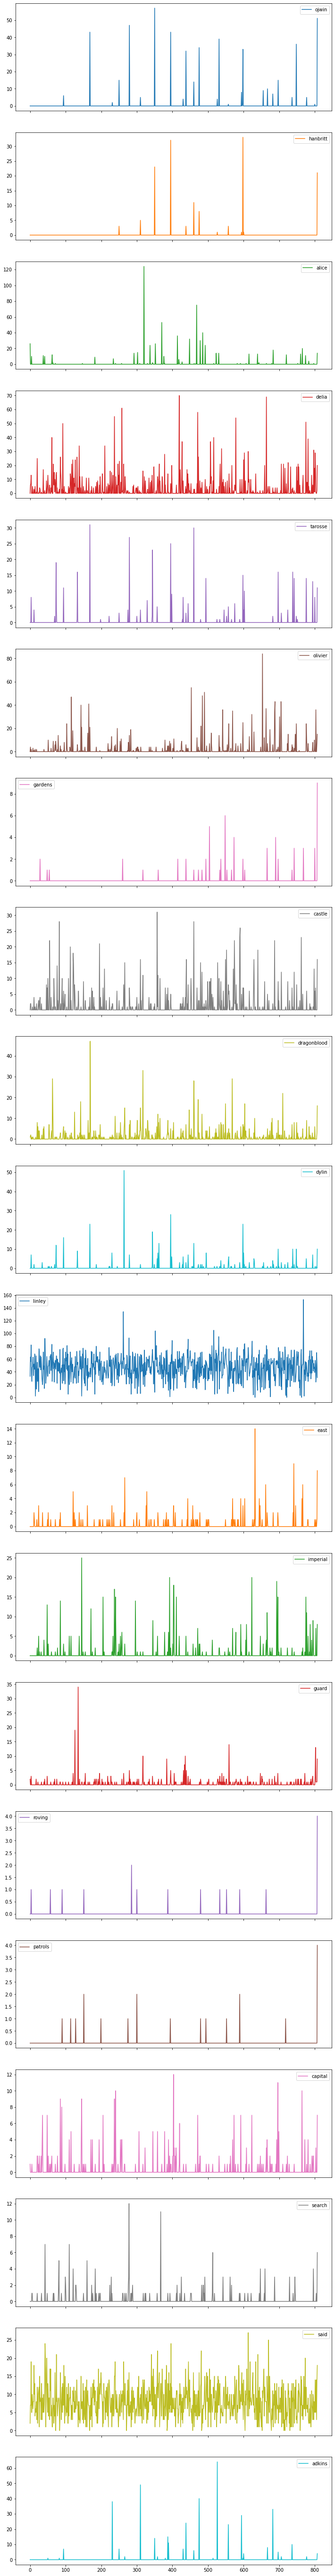

In [7]:
cv=CountVectorizer(vocabulary=top_20)
cvt=cv.fit_transform(pdf.contents)

counts = pd.DataFrame(cvt.toarray(),columns=cv.get_feature_names())

from matplotlib import pyplot as plt
counts.plot.line(subplots=True,figsize=(12,100))
#get the top 20 words in the whole book
#pull into a list
#pull vocab for each chapter 
#return the value counts for top 20 words
#graph number of occuances per word over course of book